In [9]:
import pandas as pd

# Load the dataset
df = pd.read_csv("adult_with_headers.csv")

# Display first few rows
print(df.head())

# Check data types and non-null counts
print(df.info())

# Summary statistics for numerical columns
print(df.describe())


   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2174             0              40   United-States   <=50

In [10]:
import numpy as np

# Replace '?' with NaN
df.replace(" ?", np.nan, inplace=True)

# Check missing values
print(df.isnull().sum())


age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64


In [11]:
# Impute missing categorical values with mode
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native_country'].fillna(df['native_country'].mode()[0], inplace=True)

# Verify again
print(df.isnull().sum())


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numeric_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Standard Scaling
standard_scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[numeric_cols] = standard_scaler.fit_transform(df[numeric_cols])

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numeric_cols] = minmax_scaler.fit_transform(df[numeric_cols])


# Discuss the scenarios where each scaling technique is preferred and why.

Standard Scaling (Z-score normalization) is ideal when:

Data is normally distributed or you’re applying algorithms that assume standard normal distribution (e.g., Logistic Regression, SVM, PCA).

You want to maintain the influence of outliers in your model.

Min-Max Scaling is preferred when:

You need values to fit within a specific range (usually [0, 1]), such as in neural networks or distance-based algorithms like KNN and k-means.

You want all features to contribute equally without distorting the input space.

In [13]:
# One-Hot Encoding
one_hot_cols = ['sex', 'income']  # Add 'relationship' if it has <5 unique values
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


In [14]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['workclass', 'education', 'marital_status', 'occupation', 'race', 'native_country']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])


# Discuss the pros and cons of One-Hot Encoding and Label Encoding.

In machine learning, choosing the right encoding technique for categorical variables is essential for model performance. One-Hot Encoding is ideal for categorical features with a small number of unique values and no inherent order, such as 'sex' or 'income' in the Adult dataset. It works by creating new binary columns for each category, which ensures that no ordinal relationship is implied. However, one major drawback is that it can significantly increase the dimensionality of the dataset, especially if a feature has many categories, leading to sparsity.

On the other hand, Label Encoding assigns a unique numerical value to each category and is better suited for features with many distinct categories, such as 'education' or 'native_country'. It is memory efficient and keeps the dataset compact. However, it introduces an artificial ordinal relationship between categories, which can be misleading if the model interprets the encoded values as having a meaningful order. This is usually acceptable for tree-based models but problematic for linear models. Therefore, the choice between One-Hot and Label Encoding should depend on the nature of the categorical variable and the type of model being used.

In [16]:
import pandas as pd
import numpy as np

df['capital_net'] = df['capital_gain'] - df['capital_loss']
df['hours_per_week_bucket'] = pd.cut(df['hours_per_week'], 
                                    bins=[0, 20, 40, 60, 100], 
                                    labels=['Part-time', 'Full-time', 'Over-time', 'Excessive'])


df['capital_gain_log'] = np.log1p(df['capital_gain'])


print("Skewness before:", df['capital_gain'].skew())
print("Skewness after:", df['capital_gain_log'].skew())


Skewness before: 11.953847687699799
Skewness after: 3.096143524467517


In [17]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import ppscore as pps
import matplotlib.pyplot as plt
import seaborn as sns


iso_forest = IsolationForest(contamination=0.05, random_state=42)  
outliers = iso_forest.fit_predict(df.select_dtypes(include=[np.number]))

df['outlier'] = outliers

df_clean = df[df['outlier'] == 1].drop(columns=['outlier'])

print(f"Original data shape: {df.shape}")
print(f"Data shape after removing outliers: {df_clean.shape}")


pps_matrix = pps.matrix(df_clean)

print(pps_matrix[['x', 'y', 'ppscore']].sort_values(by='ppscore', ascending=False).head(10))


corr = df_clean.select_dtypes(include=[np.number]).corr()

Original data shape: (32561, 19)
Data shape after removing outliers: (30933, 18)
                  x               y  ppscore
0               age             age      1.0
171    capital_gain    capital_gain      1.0
58        education   education_num      1.0
75    education_num       education      1.0
76    education_num   education_num      1.0
95   marital_status  marital_status      1.0
114      occupation      occupation      1.0
133    relationship    relationship      1.0
152            race            race      1.0
190    capital_loss    capital_loss      1.0


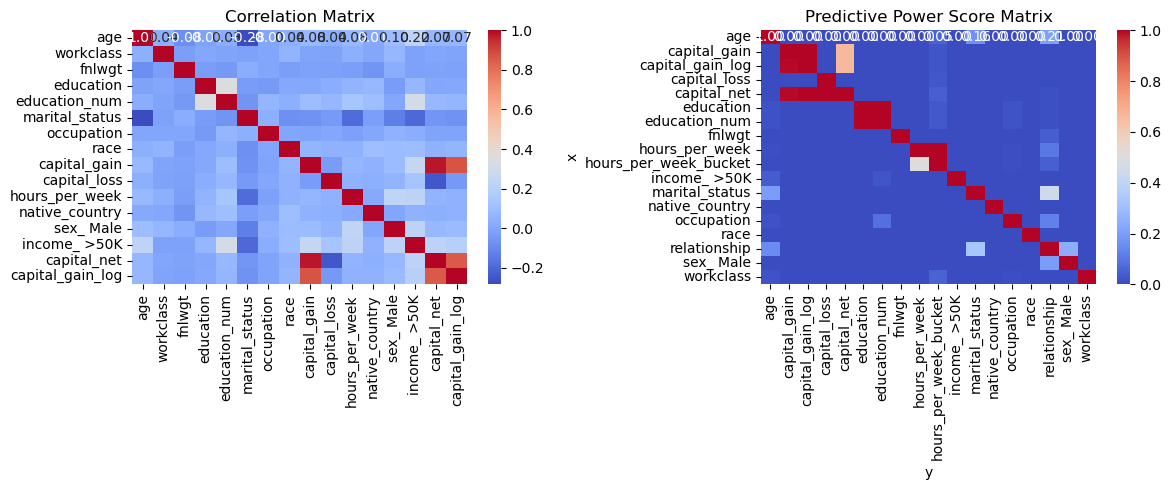

In [18]:
# Plot heatmaps
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

plt.subplot(1,2,2)
# Pivot PPS matrix to wide format for heatmap (only numerical pairs for better comparison)
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')
sns.heatmap(pps_pivot, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Predictive Power Score Matrix')

plt.tight_layout()
plt.show()
